In [1]:
from __future__ import print_function
import torchvision
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
###############
import torchvision.models as models
import imageio
from torch import autograd
from torchvision.utils import make_grid
import imageio
from IPython.display import HTML
import time
import math
manualseed = 47
random.seed(manualseed)
torch.manual_seed(manualseed)
import torch.nn.functional as F
###############
%matplotlib inline

2 Define variables

In [2]:
workers = 2 # 数据加载器能够使用的进程数量
batch_size = 64  # 训练时的批大小
weight_decay = 1e-5
# 训练图片的大小，所有的图片都将改变到该大小
image_size = 32  # 转换器使用的大小.
nc = 3  # 训练图片的通道数，彩色图片是3
nz = 100  # 本征向量z的大小(生成器的输入大小)
ngf = 32  # 生成器中特征图个数大小
ndf = 64  # 判别器中特征图个数大小
num_epochs = 50
lr = 0.0002  # 优化器学习率
beta1 = 0.5  # Adam优化器的Beta1超参
ngpu = 1  # 可利用的GPU数量，使用0将运行在CPU模式。
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

3 创建数据集

In [3]:
from torch.utils.data import Dataset, DataLoader

class Generator1(nn.Module):
    def __init__(self, ngf = 32):
        super(Generator1,self).__init__()
        self.gen=nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(110, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输入特征图大小. (nc) x 32 x 32
        )
    def forward(self, x):
        x=self.gen(x)
        return x





class FakeNumberDataset(Dataset):
    def __init__(self, dataset_name,transform=None):
        """
            mix_ratio: real/fake
        """

        if dataset_name=="mnist":
            odataset = datasets.MNIST('MNIST_data', train=True, transform=transform)
        elif dataset_name=="fashion_mnist":
            odataset = datasets.FashionMNIST('MNIST_data', train=True, transform=transform)
        elif dataset_name=="cifar10":
            odataset = datasets.CIFAR10('MNIST_data', train=True, transform=transform)
        else:
            print("Wrong argument for dataset_name!")
            return None
    


        self.label = []
        self.items = []
        ############################
        n_z=100
        ############################
        #target_num = mix_ratio * fake_images.shape[0]
        #self.added_real = 0 
#         print(len(odataset))
   
        netG1 = Generator1().to(device)
        netG1.load_state_dict(torch.load('C:\\Users\\lz172\\Desktop\\test\\netG_params.pkl'))
        for idx in range(len(odataset)):
            x_idx, y_idx = odataset[idx]
#             print(x_idx)
#             if y_idx:
#                 self.items.append(x_idx)
#                 self.label.append(y_idx)
            if y_idx:
                noise1 = torch.randn(1, 100)
                labels_onehot1 = np.zeros((1,10))
                labels_onehot1[np.arange(1),y_idx]=1 # 这个9换成想生成的数字
                noise1=np.concatenate((noise1.cpu().numpy(), labels_onehot1),axis=1)
                # 每张图片是0到9之间的数字
                labels_onehot1 = Variable(torch.from_numpy(labels_onehot1).float())
#                 labels_onehot = Variable(torch.from_numpy(labels_onehot).float())
                noise1=noise1.reshape([-1, 110, 1, 1])
                noise1=Variable(torch.from_numpy(noise1).float())                
                fake_image1 = netG1(noise1.to(device)).detach().cpu()
                fake_image_first = torch.squeeze(fake_image1,0)
                #######第二个假图片######
                noise2 = torch.randn(1, 100)
                labels_onehot2 = np.zeros((1,10))
                labels_onehot2[np.arange(1),y_idx]=1 # 这个9换成想生成的数字
                noise2=np.concatenate((noise2.cpu().numpy(), labels_onehot2),axis=1)
                # 每张图片是0到9之间的数字
                labels_onehot2 = Variable(torch.from_numpy(labels_onehot2).float())
#                 labels_onehot = Variable(torch.from_numpy(labels_onehot).float())
                noise2=noise2.reshape([-1, 110, 1, 1])
                noise2=Variable(torch.from_numpy(noise2).float())                
                fake_image2 = netG1(noise2.to(device)).detach().cpu()
                fake_image_second = torch.squeeze(fake_image2,0)
                ########################
                a1 = torch.rand(1)
                a2 = torch.rand(1)
                lamma1 = min(a1,a2)
                lamma2 = abs(a1-a2)
                lamma3 = 1-max(a1,a2)
#                 x_idx = (a1*0.25+0.25)*x_idx + (0.75-a1*0.25)*fake_image_first
                x_idx = 0.6*x_idx + 0.4*fake_image_first 
                
#                 x_idx = lamma1*x_idx + lamma2*fake_image_first+lamma3*fake_image_second
#                 print(x_idx.shape)
#                 x_idx = fake_image
                self.items.append(x_idx)
                self.label.append(y_idx)

            ##############################################
            
             

    def checkAddedRealImgs(self):
        return self.added_real
    
    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.items[idx], self.label[idx]

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        self.ngpu = ngpu
        super(Generator,self).__init__()
        self.gen=nn.Sequential(
            # 输入是 Z, 对Z进行卷积
            nn.ConvTranspose2d(110, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # 输入特征图大小. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 输入特征图大小. (nc) x 32 x 32
        )
    def forward(self, x):
        x=self.gen(x)
        return x

In [6]:

# 创建生成器
netG = Generator(ngpu).to(device)

# 如果期望使用多个GPU，设置一下。
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 使用权重初始化函数 weights_init 去随机初始化所有权重
#  mean=0, stdev=0.2.
netG.apply(weights_init)

# 输出该模型
print(netG)


Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(110, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(3, ngf, 4, 2, 1, bias=False),  #这里源码的输入1通道需要改成3通道
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*2) x 16 x 16
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*2) x 8 x 8
            nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 输入大小. (ndf*4) x 4 x 4
            nn.Conv2d(ngf * 4, 11, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [8]:
# 创建判别器
netD = Discriminator(ngpu).to(device)

# 如果期望使用多GPU，设置一下
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 使用权重初始化函数 weights_init 去随机初始化所有权重
#  mean=0, stdev=0.2.
netD.apply(weights_init)

# 输出该模型
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 11, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [9]:

# 初始化 BCE损失函数
criterion = nn.BCELoss()
criterion_pic = nn.CrossEntropyLoss()
# 创建一个批次的本征向量用于可视化生成器训练的过程。
fixed_noise = torch.randn(64, nz + 10, 1, 1, device=device)

# 建立一个在训练中使用的真实和假的标记
real_label = 1
fake_label = 0

# 为G和D都设置Adam优化器 # 刚看到说G的lr是D的lr的2倍会好一些
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [10]:
transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Mnist or FashionMnist
train_dataset_with_fake = FakeNumberDataset(dataset_name="cifar10",transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset_with_fake, batch_size=64, shuffle=True) 

# 训练循环



# 保存跟踪进度的列表
img_list = []
G_losses = []
D_losses = []
iters = 0
errD_real = float(0)
print("Starting Training Loop...")
# 每个epoh
for epoch in range(num_epochs):
    # 数据加载器中的每个批次
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) 更新 D 网络: 最大化 log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## 使用所有真实样本批次训练
        netD.zero_grad()
        # 格式化批
#         real_cpu = data[0].to(device)
#         data = Variable(data)
#         data = data.to(device)
        
        real_cpu = data[0].to(device)
        ############reshape real_cpu###########
#         real_cpu = torch.cat((real_cpu,real_cpu,real_cpu),1)
        #######################################
        
#         print(real_cpu.shape)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device,dtype=torch.float)
        
        
#         print(real_cpu.shape)
        # 通过D向前传递真实批次的feature map
        output = netD(real_cpu)
#         print(output.shape)
        output = output.view(b_size,11)
#         print(output.shape)
        # output = output.view([b_size, 11]　　　　　
        real_label_label = output[:, 0]  # 第一维就是预测是否是真实图片
        real_label_pic = output[:, 1:]  # 后十维是onehot，判断是哪个数字
#         print(real_label_pic.shape)
        # 对所有真实样本批次计算损失
#         print(label.shape)
#         print(real_label_label.shape)
        errD_real = criterion(real_label_label, label)
        errD_real.backward(retain_graph=True)  # 连续多个backward，除了最后一个不叫retain_graph=True,其余都要加

        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device))
        errD_fake_pic.backward()

        # 计算后向传递中D的梯度

        D_x = real_label_label.mean().item()

        ## 使用所有假样本批次训练
        # 生成本征向量批次
        #   noise = torch.randn(b_size, nz+10, 1, 1, device=device)  # 注释这行表示输入110维的noise，也就是DCGAN的输入
        noise = torch.randn(b_size, nz, device=device)

        labels_onehot = np.zeros((b_size, 10))
        labels_onehot[np.arange(b_size), data[1].numpy()] = 1
        noise = np.concatenate((noise.cpu().numpy(), labels_onehot), axis=1)
        # 每张图片是0到9之间的数字
        labels_onehot = Variable(torch.from_numpy(labels_onehot).float()).to(device)
        noise = noise.reshape([-1, 110, 1, 1])
        noise = Variable(torch.from_numpy(noise).float()).to(device)

        # 使用生成器G生成假图片
        fake = netG(noise)
        label.fill_(fake_label)                               
        
        
        
    
        
        
        # 使用判别器分类所有的假批次样本的feature map
        output = netD(fake.detach())
        # 计算判别器D的损失对所有的假样本批次
        #         output = output.view([b_size, 11])
        output = output.view([b_size, 11])
        real_label_label = output[:, 0]
        real_label_pic = output[:, 1:]
        errD_fake = criterion(real_label_label, label)
        # 对这个批次计算梯度
        errD_fake.backward(retain_graph=True)
        
#         errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) + 0.2*loss1
        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) 
        errD_fake_pic.backward(retain_graph=True)
        D_G_z1 = real_label_label.mean().item()
        # 把所有真样本和假样本批次的梯度加起来
        errD = errD_real + errD_fake + errD_fake_pic 
        # 更新判别器D
        optimizerD.step()

        ############################
        # (2) 更新 G 网络: 最大化 log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 假样本的标签对于生成器成本是真的
        # 因为我们之更新了D，通过D执行所有假样本批次的正向传递
        output = netD(fake).view(-1) #这里是将netD的输入fake换成了fake_feature
        # 基于这个输出计算G的损失
        output = output.view([b_size, 11])
        real_label_label = output[:, 0]
        real_label_pic = output[:, 1:]
        errG = criterion(real_label_label, label)
        # 为生成器计算梯度
        errG.backward(retain_graph=True)
#         errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) + 0.2*loss1
        errD_fake_pic = criterion_pic(real_label_pic, data[1].cuda(device)) 
        errD_fake_pic.backward()
        D_G_z2 = output.mean().item()
        # 更新生成器G
        optimizerG.step()

        # 输出训练状态
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 为以后画损失图，保存损失
        G_losses.append(errG.item())
        D_losses.append(errD.item())
#         print(0)

        # 检查生成器generator做了什么，通过保存的fixed_noise通过G的输出
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
print("Congratulations! Training Finished!")

Starting Training Loop...
[0/50][0/704]	Loss_D: 3.8779	Loss_G: 1.0039	D(x): 0.4706	D(G(z)): 0.5275 / 0.4854
[0/50][50/704]	Loss_D: 2.7347	Loss_G: 2.9781	D(x): 0.8309	D(G(z)): 0.2329 / 0.4009
[0/50][100/704]	Loss_D: 2.5449	Loss_G: 4.0276	D(x): 0.8644	D(G(z)): 0.1365 / 0.3423
[0/50][150/704]	Loss_D: 2.5286	Loss_G: 3.7552	D(x): 0.8288	D(G(z)): 0.0979 / 0.3373
[0/50][200/704]	Loss_D: 2.8124	Loss_G: 2.9319	D(x): 0.7658	D(G(z)): 0.2670 / 0.3142
[0/50][250/704]	Loss_D: 2.6131	Loss_G: 2.7947	D(x): 0.7890	D(G(z)): 0.1568 / 0.3271
[0/50][300/704]	Loss_D: 2.7773	Loss_G: 2.0686	D(x): 0.6939	D(G(z)): 0.2534 / 0.2891
[0/50][350/704]	Loss_D: 2.8670	Loss_G: 1.9148	D(x): 0.6202	D(G(z)): 0.1938 / 0.2830
[0/50][400/704]	Loss_D: 2.9321	Loss_G: 1.8306	D(x): 0.6030	D(G(z)): 0.3100 / 0.2601
[0/50][450/704]	Loss_D: 2.8514	Loss_G: 1.5146	D(x): 0.5904	D(G(z)): 0.3466 / 0.2429
[0/50][500/704]	Loss_D: 2.6294	Loss_G: 2.0021	D(x): 0.7827	D(G(z)): 0.4719 / 0.2077
[0/50][550/704]	Loss_D: 2.5555	Loss_G: 1.3070	D(x): 0

[6/50][350/704]	Loss_D: 2.4061	Loss_G: 1.4373	D(x): 0.6587	D(G(z)): 0.3843 / 0.1204
[6/50][400/704]	Loss_D: 2.6442	Loss_G: 1.3181	D(x): 0.5707	D(G(z)): 0.4074 / 0.1247
[6/50][450/704]	Loss_D: 2.7492	Loss_G: 1.7928	D(x): 0.7690	D(G(z)): 0.6129 / 0.1146
[6/50][500/704]	Loss_D: 2.6451	Loss_G: 0.9528	D(x): 0.5108	D(G(z)): 0.3598 / 0.1347
[6/50][550/704]	Loss_D: 2.5637	Loss_G: 1.4256	D(x): 0.6606	D(G(z)): 0.4514 / 0.1256
[6/50][600/704]	Loss_D: 2.6093	Loss_G: 1.2155	D(x): 0.5552	D(G(z)): 0.3984 / 0.1266
[6/50][650/704]	Loss_D: 2.5455	Loss_G: 1.6408	D(x): 0.6408	D(G(z)): 0.4311 / 0.1210
[6/50][700/704]	Loss_D: 2.5477	Loss_G: 1.6383	D(x): 0.5052	D(G(z)): 0.2677 / 0.1165
[7/50][0/704]	Loss_D: 3.1183	Loss_G: 2.4228	D(x): 0.7911	D(G(z)): 0.7251 / 0.1078
[7/50][50/704]	Loss_D: 2.6088	Loss_G: 1.3882	D(x): 0.6559	D(G(z)): 0.4866 / 0.1214
[7/50][100/704]	Loss_D: 2.6136	Loss_G: 1.4708	D(x): 0.5655	D(G(z)): 0.3985 / 0.1189
[7/50][150/704]	Loss_D: 2.6958	Loss_G: 1.5483	D(x): 0.5644	D(G(z)): 0.4567 / 0.

[12/50][700/704]	Loss_D: 2.6445	Loss_G: 1.2749	D(x): 0.5914	D(G(z)): 0.4501 / 0.1249
[13/50][0/704]	Loss_D: 2.8070	Loss_G: 1.4707	D(x): 0.6021	D(G(z)): 0.5198 / 0.1182
[13/50][50/704]	Loss_D: 2.7659	Loss_G: 1.7854	D(x): 0.7188	D(G(z)): 0.5971 / 0.1133
[13/50][100/704]	Loss_D: 2.7682	Loss_G: 1.1732	D(x): 0.5598	D(G(z)): 0.4734 / 0.1279
[13/50][150/704]	Loss_D: 2.7290	Loss_G: 0.8858	D(x): 0.5078	D(G(z)): 0.3992 / 0.1329
[13/50][200/704]	Loss_D: 2.7106	Loss_G: 1.2210	D(x): 0.5877	D(G(z)): 0.4759 / 0.1245
[13/50][250/704]	Loss_D: 2.6602	Loss_G: 1.4740	D(x): 0.6489	D(G(z)): 0.5063 / 0.1187
[13/50][300/704]	Loss_D: 2.7692	Loss_G: 1.1155	D(x): 0.5371	D(G(z)): 0.4424 / 0.1309
[13/50][350/704]	Loss_D: 2.7080	Loss_G: 1.5386	D(x): 0.6177	D(G(z)): 0.4953 / 0.1171
[13/50][400/704]	Loss_D: 2.7045	Loss_G: 1.7258	D(x): 0.6994	D(G(z)): 0.5609 / 0.1128
[13/50][450/704]	Loss_D: 2.7634	Loss_G: 0.7925	D(x): 0.4161	D(G(z)): 0.2965 / 0.1367
[13/50][500/704]	Loss_D: 2.6840	Loss_G: 1.1325	D(x): 0.5214	D(G(z)):

[19/50][250/704]	Loss_D: 2.6055	Loss_G: 1.4738	D(x): 0.6285	D(G(z)): 0.4692 / 0.1167
[19/50][300/704]	Loss_D: 2.7780	Loss_G: 1.1319	D(x): 0.5994	D(G(z)): 0.5160 / 0.1254
[19/50][350/704]	Loss_D: 2.6131	Loss_G: 1.2290	D(x): 0.5951	D(G(z)): 0.4330 / 0.1228
[19/50][400/704]	Loss_D: 2.7370	Loss_G: 0.8770	D(x): 0.4764	D(G(z)): 0.3646 / 0.1379
[19/50][450/704]	Loss_D: 2.7458	Loss_G: 1.0487	D(x): 0.4850	D(G(z)): 0.3894 / 0.1288
[19/50][500/704]	Loss_D: 2.7727	Loss_G: 0.8458	D(x): 0.4718	D(G(z)): 0.3852 / 0.1348
[19/50][550/704]	Loss_D: 2.7459	Loss_G: 0.8082	D(x): 0.4436	D(G(z)): 0.3197 / 0.1393
[19/50][600/704]	Loss_D: 2.5964	Loss_G: 1.1657	D(x): 0.5629	D(G(z)): 0.3931 / 0.1238
[19/50][650/704]	Loss_D: 2.6283	Loss_G: 1.5717	D(x): 0.7011	D(G(z)): 0.5288 / 0.1156
[19/50][700/704]	Loss_D: 2.7857	Loss_G: 0.9702	D(x): 0.4334	D(G(z)): 0.3360 / 0.1302
[20/50][0/704]	Loss_D: 2.4751	Loss_G: 1.4180	D(x): 0.6331	D(G(z)): 0.4048 / 0.1162
[20/50][50/704]	Loss_D: 2.5986	Loss_G: 1.1202	D(x): 0.5647	D(G(z)):

[25/50][550/704]	Loss_D: 2.7428	Loss_G: 1.1951	D(x): 0.5694	D(G(z)): 0.4808 / 0.1220
[25/50][600/704]	Loss_D: 2.7402	Loss_G: 1.4492	D(x): 0.5748	D(G(z)): 0.4875 / 0.1194
[25/50][650/704]	Loss_D: 2.5649	Loss_G: 1.2340	D(x): 0.5695	D(G(z)): 0.3867 / 0.1204
[25/50][700/704]	Loss_D: 2.7108	Loss_G: 1.2849	D(x): 0.5704	D(G(z)): 0.4705 / 0.1206
[26/50][0/704]	Loss_D: 2.7393	Loss_G: 1.8634	D(x): 0.6690	D(G(z)): 0.5278 / 0.1106
[26/50][50/704]	Loss_D: 2.6907	Loss_G: 1.2366	D(x): 0.5879	D(G(z)): 0.4702 / 0.1199
[26/50][100/704]	Loss_D: 2.7486	Loss_G: 1.0590	D(x): 0.5315	D(G(z)): 0.4494 / 0.1268
[26/50][150/704]	Loss_D: 2.8037	Loss_G: 0.9761	D(x): 0.4668	D(G(z)): 0.3957 / 0.1301
[26/50][200/704]	Loss_D: 2.6471	Loss_G: 1.2671	D(x): 0.6245	D(G(z)): 0.4780 / 0.1203
[26/50][250/704]	Loss_D: 2.6918	Loss_G: 1.3607	D(x): 0.5798	D(G(z)): 0.4699 / 0.1168
[26/50][300/704]	Loss_D: 2.8140	Loss_G: 0.8198	D(x): 0.4427	D(G(z)): 0.3610 / 0.1346
[26/50][350/704]	Loss_D: 2.6870	Loss_G: 1.0421	D(x): 0.5436	D(G(z)):

[32/50][100/704]	Loss_D: 2.9162	Loss_G: 0.7568	D(x): 0.3247	D(G(z)): 0.2222 / 0.1379
[32/50][150/704]	Loss_D: 2.6845	Loss_G: 1.0596	D(x): 0.5674	D(G(z)): 0.4473 / 0.1289
[32/50][200/704]	Loss_D: 2.7759	Loss_G: 1.2083	D(x): 0.5591	D(G(z)): 0.4867 / 0.1233
[32/50][250/704]	Loss_D: 2.7529	Loss_G: 0.9950	D(x): 0.4979	D(G(z)): 0.4022 / 0.1278
[32/50][300/704]	Loss_D: 2.8417	Loss_G: 0.9478	D(x): 0.4780	D(G(z)): 0.4357 / 0.1341
[32/50][350/704]	Loss_D: 2.6594	Loss_G: 1.0166	D(x): 0.5027	D(G(z)): 0.3663 / 0.1285
[32/50][400/704]	Loss_D: 2.7166	Loss_G: 0.9037	D(x): 0.4909	D(G(z)): 0.3828 / 0.1301
[32/50][450/704]	Loss_D: 2.7536	Loss_G: 0.9312	D(x): 0.4548	D(G(z)): 0.3445 / 0.1306
[32/50][500/704]	Loss_D: 2.8197	Loss_G: 0.9657	D(x): 0.5235	D(G(z)): 0.4684 / 0.1291
[32/50][550/704]	Loss_D: 2.7687	Loss_G: 1.1040	D(x): 0.5579	D(G(z)): 0.4859 / 0.1245
[32/50][600/704]	Loss_D: 2.7399	Loss_G: 1.3398	D(x): 0.6875	D(G(z)): 0.5758 / 0.1185
[32/50][650/704]	Loss_D: 2.7770	Loss_G: 1.1585	D(x): 0.5289	D(G(z

[38/50][400/704]	Loss_D: 2.7153	Loss_G: 1.0242	D(x): 0.5451	D(G(z)): 0.4385 / 0.1330
[38/50][450/704]	Loss_D: 2.6514	Loss_G: 1.3533	D(x): 0.6443	D(G(z)): 0.5030 / 0.1195
[38/50][500/704]	Loss_D: 2.7240	Loss_G: 1.1602	D(x): 0.6218	D(G(z)): 0.5207 / 0.1223
[38/50][550/704]	Loss_D: 2.7373	Loss_G: 1.0717	D(x): 0.5127	D(G(z)): 0.4216 / 0.1262
[38/50][600/704]	Loss_D: 2.6477	Loss_G: 1.2830	D(x): 0.5676	D(G(z)): 0.4365 / 0.1200
[38/50][650/704]	Loss_D: 2.9098	Loss_G: 0.7344	D(x): 0.4354	D(G(z)): 0.4065 / 0.1368
[38/50][700/704]	Loss_D: 2.9735	Loss_G: 0.9763	D(x): 0.4681	D(G(z)): 0.4824 / 0.1283
[39/50][0/704]	Loss_D: 2.8434	Loss_G: 1.1309	D(x): 0.5432	D(G(z)): 0.4900 / 0.1232
[39/50][50/704]	Loss_D: 2.7376	Loss_G: 1.0676	D(x): 0.4831	D(G(z)): 0.3814 / 0.1278
[39/50][100/704]	Loss_D: 2.8200	Loss_G: 0.9719	D(x): 0.5343	D(G(z)): 0.4785 / 0.1276
[39/50][150/704]	Loss_D: 2.9205	Loss_G: 0.5911	D(x): 0.3788	D(G(z)): 0.3455 / 0.1437
[39/50][200/704]	Loss_D: 2.7388	Loss_G: 1.3368	D(x): 0.6630	D(G(z)):

[44/50][700/704]	Loss_D: 2.8571	Loss_G: 0.8278	D(x): 0.4359	D(G(z)): 0.3990 / 0.1370
[45/50][0/704]	Loss_D: 3.0411	Loss_G: 1.6906	D(x): 0.7447	D(G(z)): 0.6982 / 0.1147
[45/50][50/704]	Loss_D: 2.7407	Loss_G: 0.9665	D(x): 0.5105	D(G(z)): 0.4255 / 0.1280
[45/50][100/704]	Loss_D: 2.8082	Loss_G: 1.2761	D(x): 0.6173	D(G(z)): 0.5526 / 0.1202
[45/50][150/704]	Loss_D: 2.7814	Loss_G: 1.3064	D(x): 0.6164	D(G(z)): 0.5389 / 0.1184
[45/50][200/704]	Loss_D: 2.7566	Loss_G: 1.1739	D(x): 0.5954	D(G(z)): 0.5088 / 0.1231
[45/50][250/704]	Loss_D: 2.7632	Loss_G: 1.0835	D(x): 0.5442	D(G(z)): 0.4779 / 0.1268
[45/50][300/704]	Loss_D: 2.8172	Loss_G: 0.9629	D(x): 0.4566	D(G(z)): 0.4009 / 0.1292
[45/50][350/704]	Loss_D: 2.8117	Loss_G: 0.8576	D(x): 0.4383	D(G(z)): 0.3700 / 0.1317
[45/50][400/704]	Loss_D: 2.7925	Loss_G: 1.0613	D(x): 0.5579	D(G(z)): 0.4987 / 0.1255
[45/50][450/704]	Loss_D: 2.7299	Loss_G: 0.9495	D(x): 0.5416	D(G(z)): 0.4459 / 0.1294
[45/50][500/704]	Loss_D: 2.7706	Loss_G: 1.0672	D(x): 0.5111	D(G(z)):

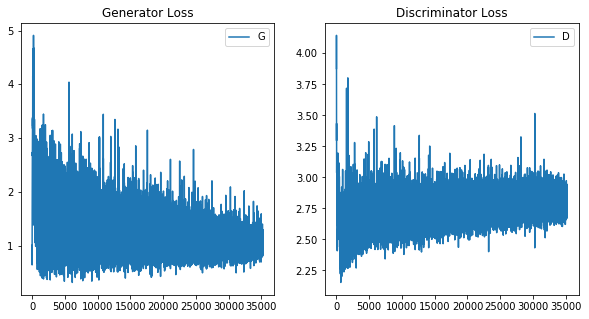

In [11]:
#Draw Losses
# 对照组
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Generator Loss")
plt.plot(G_losses,label="G")
plt.legend()
plt.subplot(1,2,2)
plt.title("Discriminator Loss")
plt.plot(D_losses,label="D")
# plt.plot(D_penalties,label="D_penalty")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
plt.legend()
plt.show()

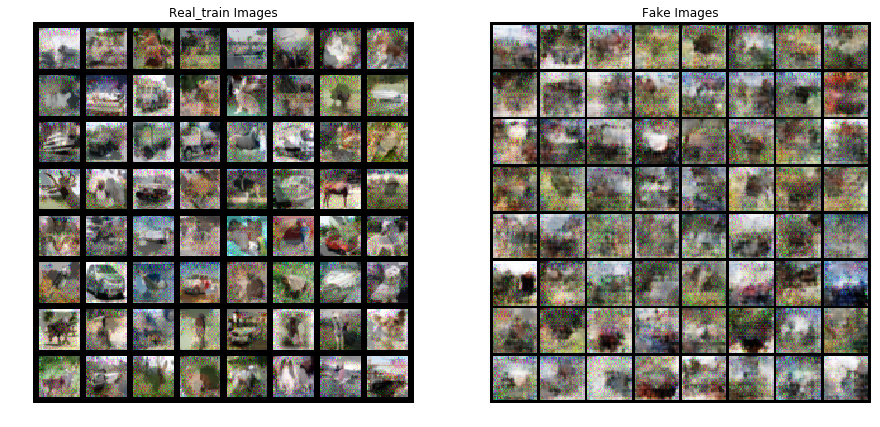

In [13]:
torch.save(netG.state_dict(), "C:\\Users\\lz172\\Desktop\\attacker-cifar10\\netG_params.pkl")
# 从数据加载器中获取一批真实图像
real_batch = next(iter(dataloader))

# 画出真实图像
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real_train Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 画出来自最后一次训练的假图像
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


torch.Size([8, 3, 32, 32])


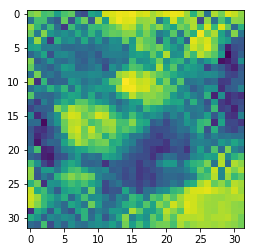

In [14]:
torch.save(netG.state_dict(), "C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-models\\CGAN-Clear-Generator-MaxLogVar48-epoch60-Fashion_MNIST-6\\netG_params.pkl")
torch.save(netD.state_dict(), "C:\\Users\\lz172\\Desktop\\jupyter\\defense-fl-gan-attack-main\\saved-models\\CGAN-Clear-Discriminator-MaxLogVar48-epoch60-Fashion_MNIST-6\\netD_params.pkl")


noise = torch.randn(b_size, nz, device=device)       
labels_onehot = np.zeros((b_size,10))
labels_onehot[np.arange(b_size),0]=1 # 这个9换成想生成的数字
noise=np.concatenate((noise.cpu().numpy(), labels_onehot),axis=1)
# 每张图片是0到9之间的数字
labels_onehot = Variable(torch.from_numpy(labels_onehot).float()).to(device)
noise=noise.reshape([-1, 110, 1, 1])
# print(noise.shape)
noise=Variable(torch.from_numpy(noise).float()).to(device)

# 使用生成器G生成假图片
fake = netG(noise)
# fake = torch.squeeze((fake),0)
print(fake.shape)
plt.imshow(fake.cpu().detach().numpy()[5][0])